# Reconstructing Images from Their Binary Representations Using Fully Convolutional Neural Networks

Reconstruct the original MNIST images from their binary representations with a fully convolutional neural network. We can think of the binary representation as a sparsely sampled version of the original image. **Fully convolutional** indicates that the neural network structure is composed of only convolutional layers without any fully-connected layers or MLP at the end of the network. Fully convolutional networks are pixel-to-pixel networks that can efficiently learn to make dense predictions in per-pixel tasks, such as segmentation and image restoration. 

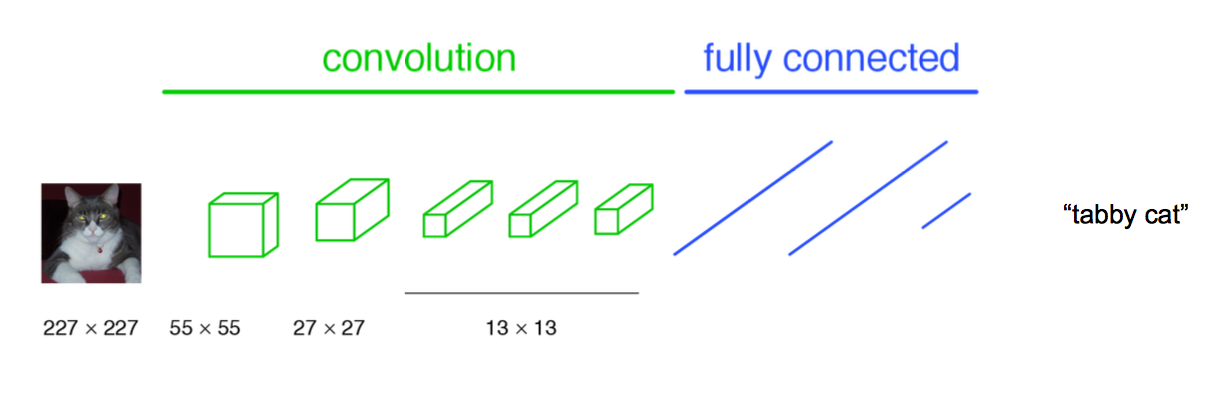

In [11]:
from IPython.display import Image
Image(filename='images/classificationNetwork.png',height=500,width=500)

A fully convolutional neural network for a segmentation purpose might look like this:

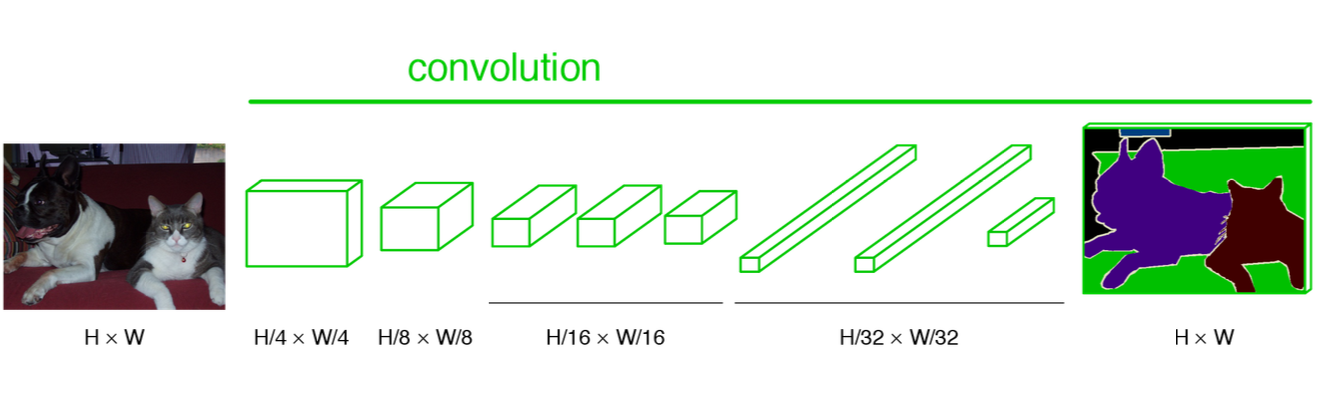

In [12]:
Image(filename='images/fullyConvolutionalNetwork.png',height=600,width=600)

The architecture for the task will look like the figure below:

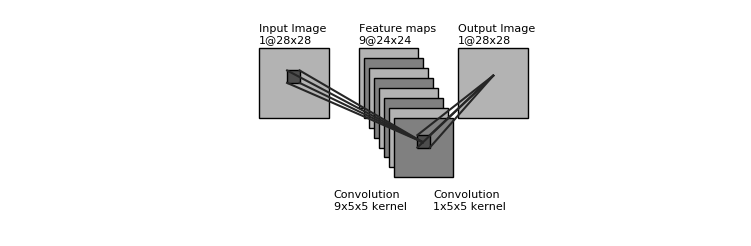

In [13]:
from IPython.display import Image
Image(filename='images/convnetStructureforDemo.png',height=800,width=800)

The specs for our fully convolutional neural network will be:

1. Input layer
    + Consists of a channel of a grid of 28x28 pixels (units)
    + Takes a binarized MNIST image as its input
    + Two different binarization techiques will be considered (see below)
    + Pixel values are in the set $\{0,1\}$
2. Hidden layer (convolutional layer):
    + 9 channels (feature planes/feature maps)
    + Weight kernel size (per feature plane/map): 5x5
    + Valid border mode convolution (no padding)
    + Tanh non-linearity
    + No pooling
    + Stride number: 1
3. Output layer (convolutional layer):
    + 1 channel
    + Weight kernel size: 5x5x9
    + Full border mode convolution (zero padding)
    + Sigmoid non-linearity
    + No pooling
    + Stride number: 1

The network is composed of two convolutional layers. Both of them applies convolution to its input, followed by hyperbolic tangent (*tanh*) in the first convolutional layer and *sigmoid* in the second convolutional layer. In addition to this difference, the border modes (see [Theano tutorial](http://deeplearning.net/software/theano/library/tensor/nnet/conv.html)) will be different. The first convolutional layer will use **'valid'**, where the output will be smaller than the input because the convolution is only computed where the input and the filter fully overlap. The second convolutional layer will have **'full'** border mode to produce the output which will have the same size as the original image, since the filter can go even further outside the bounds of the input in this border mode.

For more information about bordering modes (also strides in convolutional arithmetic) you can check [this github page:](https://github.com/vdumoulin/conv_arithmetic).

Let's start the exercise by importing necessary Python libraries

In [14]:
import six.moves.cPickle as pickle
import matplotlib.pyplot as plt
import gzip
import os, sys
import numpy as np 
import theano
import theano.tensor as T
from theano.tensor.nnet import conv2d
from exercise_helper import load_data
print('***** Import complete *****')

***** Import complete *****


Now we load (or upload) the MNIST dataset. Different from the previous architecture, now we do not need the labels of the dataset, since we only want to reconstruct the original image from the dataset. Therefore we only get the images of dimension 28 x 28 pixels and flatten them to an array of 784 elements.

In [15]:
dataset = 'mnist.pkl.gz'
datasets = load_data(dataset)

train_set_x = datasets[0]
test_set_x  = datasets[2]
print('Training set: %d samples' %(train_set_x.get_value(borrow=True).shape[0]))
print('Test set: %d samples' %(test_set_x.get_value(borrow=True).shape[0]))

***** Loading data *****
Training set: 6000 samples
Test set: 2000 samples


After loading the dataset, we define the random seed and hyperparameters for our model and for the training.

In [16]:
# random seed to initialize the pseudo-random number generator
rng = np.random.RandomState(23455)
# some hyperparameters
learning_rate = 0.1
num_epochs = 3
num_filters = [9, 1]
batch_size = 64

# compute number of minibatches for training and test dataset
n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
n_test_batches  = test_set_x.get_value(borrow=True).shape[0] // batch_size
print('number of train batches: %d'% 
      (n_train_batches))
print('number of test batches: %d'% 
      (n_test_batches))

number of train batches: 93
number of test batches: 31


At this point, we can select a random sample from the training set and check the binarized version of it. Here, we have the following options for binarization:

+ **Simple Rounding:** Round all values above a globally determined threshold (here threshold=0.5) to True's (1's) and set all other values to False's (0's).

+ **Stochastic Rounding:** Round numbers at each stage randomly by selecting a threshold for each pixel based on uniform distribution. Rounding will give the nearest integer with a probability dependent on the proximity and lead to an unbiased result on average. For instance, 0.7 would be rounded to 1 with probability 0.7 and to 0 with probability 0.3. We select the probabilities randomly from uniform distribution over $[0, 1)$ and check $int(math.floor(x + random.random()))$.

In the current mode, stochastic rounding is applied to get the binary images. However, you can see that the code for simple rounding as commented out. After running our first experiment with the stochastic rounding, we will also run the same experiment with the simple rounding. The effect of simple rounding and stochastic rounding can be seen in the resulting images.

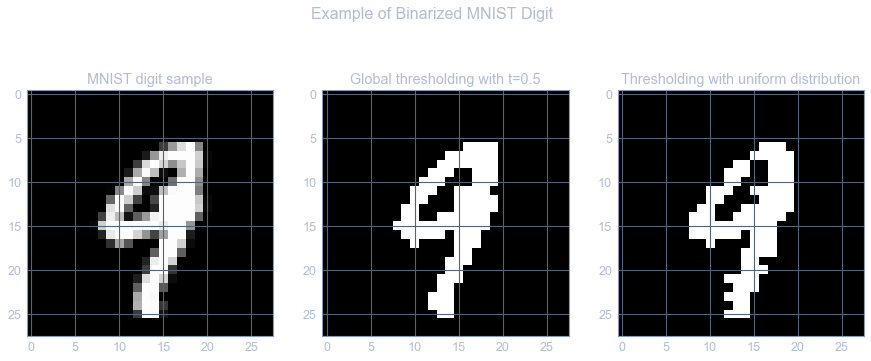

In [17]:
# get the dimensions for input images
import math
D = train_set_x.get_value(borrow=True).shape[1]
L = train_set_x.get_value(borrow=True).shape[0]
W = int(math.sqrt(D))
assert W * W == D

# randomly sample a test image from the first batch
ind = np.random.randint(batch_size)
test_set_sample = test_set_x[ind].eval()
# create two binarized versions of the same sample
test_set_sample_binarized_ver1 = (test_set_x[ind].eval() > 0.5)
test_set_sample_binarized_ver2 = ((test_set_x[ind].eval() + np.random.rand(D)) > 1.0)
# plotting function to show binarized images
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.set_title('MNIST digit sample')
ax2.set_title('Global thresholding with t=0.5')
ax3.set_title('Thresholding with uniform distribution')
plt.suptitle('Example of Binarized MNIST Digit', fontsize=16)
ax1.imshow(
    test_set_sample.reshape(W,W).astype('float32'), cmap='gray')
ax2.imshow(
    test_set_sample_binarized_ver1.reshape(W,W).astype('float32'), cmap='gray') 
ax3.imshow(
    test_set_sample_binarized_ver2.reshape(W,W).astype('float32'), cmap='gray')
plt.show()

Now, we can create the function for a convolutional layer. It should be noted that this convolutional layer function is a little bit different from the one used in the second week exercise session. In this function, we can also tune more things in addition to the activation function:

1. Bias initialization
2. Border mode for the convolution operation
3. Update mechanism for paramaters **W** and **B**. 

We know that convolutional neural networks have the parameter sharing property, which means that a single bias and the same weights for filter is used in one convolution for every location. We applied this parameter sharing property in the second exercise, where the filter weights are initialized with samples from the normal distribution and bias for each channel are initialized to 0. 

Actualy, we might add bias in two ways: 

+ **tied (shared) bias initialization/learning:** Classical method where a one single bias is used throughout a one convolution. Bias starts from a single value and optimized during the training.
+ **untied (non-shared) bias initialization/learning:** Each activation function of a neuron has a different bias leading to increase the model complexity. The dimension of the bias will be the same as the width and height of the convolutional layer output.

Biases in convolutional layers increase the capacity of the model and making it theoratically able to represent more complex data. Therefore, if the problem is simple enough, the non-shared initialization might be unnecessary.
 
Since bias will be defined as tensor variable similar to exercise 2, we again use **dimshuffle** to determine the shape of broadcastable tensor variables. For examples of dimshuffle you can visit the [Theano tutorial](http://deeplearning.net/software/theano/library/tensor/basic.html).

In [18]:
def conv_layer(rng, input, image_shape, filter_shape, border_mode, activation, bias):
    # Inputs:
    # rng - Random number generator
    # input - Symbolic image tensor
    # image_shape - dimensions of input image 
    #              tuple or list of length 4
    #              (batch size, depth, image height, image width)
    # filter_shape - dimensions of filter in convolution layer
    #               tuple or list of length 4:
    #               (number of channels, depth, height, width)
    # border_mode - border mode for convolution function 
    # activation - activation function to be used
    # bias - value for the initial bias 
    # No pooling layer 
    
    # Outputs:
    # output - tensor containing activations fed into next layer
    # params - list containing layer parameters

    assert image_shape[1] == filter_shape[1]

    # initialize weights with random weights 
    # and assign a shared variable to weights with samples
    # drawn from a gaussian distribution with 0 mean and standard deviation of 
    # 0.1. This is just a random initialization.
    W = theano.shared(
        np.asarray(rng.normal(loc=0, scale=0.1, size=filter_shape)),
        borrow=True)

    # convolve input with the specified type of kernel
    # Theano function takes as input the data tensor, filter weights, filter 
    # specifications, image specifications and the convolution mode
    # in our example, the dimensions of the output of this operation would be:
    # mini_batch_size x 9 x 24 x 24
    conv_out = conv2d(input=input, 
                      filters=W, 
                      filter_shape=filter_shape, 
                      input_shape=image_shape, 
                      border_mode=border_mode)

    # (no pooling)

    # initialization of the biases
    if bias is None:
        # if no specs for bias is given
        # bias is a 1D tensor, one bias per output feature map. 
        # initialize to zero and assign a shared variable to bias
        b_values = np.zeros((filter_shape[0],), dtype=theano.config.floatX)
        b = theano.shared(value=b_values, borrow=True)
    else:
        # otherwise assign 1D or 2D tensor based on the initializations 
        b = theano.shared(value=bias, borrow=True)

    # Before adding the bias term to the specified activation function,
    # check the dimensions of bias shared variable.
    # We use b.dimshuffle to obtain a view of the bias tensor b that
    # enables broadcasting the bias values appropriately.
    # In this case, our bias tensor is originally of the dimension 9 x 1.
    if len(b.eval().shape) < 2: 
        # add the bias term. Since the bias is a 1D array tensor, we first
        # dimshuffle it to a tensor of shape (1, # of channels, 1, 1),
        # e.g. (1, 9, 1, 1)
        output = activation(conv_out + b.dimshuffle('x', 0, 'x', 'x'))
    else:
        # add the bias term 
        # Since the bias is a 2D array tensor, we first 
        # dimshuffle it to a tensor of shape (1, 1, image_shape[0], image_shape[1]),
        # i.e. (1, 1, 28, 28)
        output = activation(conv_out + b.dimshuffle('x', 'x', 0, 1))
        
    # return output and parameters as a single list
    params = [W,b]
    return output, params

Now, we can create our convolutional model. First, we will allocate symbolic variables for the data and binarize the input. After that, we will build the first convolutional layer with 9 channels, each of them having a kernel size of 5x5, tanh nonlinearity and no pooling. The second convolutional layer will have 1 channel (as the output image) with 5x5 kernel, sigmoid nonlinearity and no pooling. The border mode of the first layer will be **valid**, and the second layer will be **full** to reconstruct the original MNIST size.

In [19]:
print('... building the conv model')
# allocate symbolic variables for the data
# minibatch index
index = T.lscalar() 
# the input presented as rasterized images
x = T.matrix('x') 
    
# reshape matrix of rasterized images of shape (batch_size x W x W), W=28
# to a 4D tensor to produce MNIST images with a size of  
# (mini_batch_size x 1 x 28 x 28)
input_layer = x.reshape((batch_size, 1, W, W))

# binarize the input layer 4D tensor with simple rounding
# input_layer_binarized = ((input_layer + 
#                          0.5) > 1.0).astype(theano.config.floatX)

# binarize the input layer 4D tensor with stochastic rounding
input_layer_binarized = ((input_layer + 
                          np.random.rand(batch_size,1,W,W)) > 1.0).astype(theano.config.floatX)


# construct the first convolutional pooling layer:
# filtering reduces the image size to (24, 24)
# no pooling
# 4D output tensor is thus of shape (mini_batch_size, num_filters[0], 24, 24)
[hidden_layer_output, 
 hidden_layer_params] = conv_layer(
                            rng, 
                            input=input_layer_binarized, 
                            image_shape=(batch_size, 1, 28, 28), 
                            filter_shape=(num_filters[0], 1, 5, 5), 
                            border_mode='valid', 
                            activation = T.tanh, bias=None)

# construct the second convolutional layer for output
# filtering increases the image size to (28, 28)
# no pooling
# 4D output tensor is thus of shape (mini_batch_size, num_filters[1], 28, 28)
[output, 
 output_layer_params] = conv_layer(
                            rng, input=hidden_layer_output, 
                            image_shape=(batch_size, num_filters[0], 24, 24), 
                            filter_shape=(num_filters[1], num_filters[0], 5, 5), 
                            border_mode='full', 
                            activation = T.nnet.sigmoid, bias=None)


... building the conv model


Since the problem can be seen as a regression problem, instead of cross-entropy error, we compute the cost function with Mean Squared Error (MSE) to calculate the deviations between the reconstructed image $\hat{\mathbf{Y}}$ and the original MNIST image $\mathbf{Y}$:
$$ J(f(\mathbf{X}^{(i)}; \theta), \mathbf{Y}^{(i)}) = \frac{1}{N}\sum_{i=1}^{N}(\hat{\mathbf{Y}}_i -\mathbf{Y}_i)^2$$

In this demo, we will update parameters with a simple vanilla SGD (Stochastic Gradient Descent) by changing the parameters along the negative gradient direction. It iterates and minimizes the cost over mini-batches instead of over the whole training set, which we would do with standard batch gradient descent. SGD is more noisy, but can also help to escape from saddle points or local minima/maxima. In extreme case, the stochastic gradient descent can have a mini-batch size of only one sample, in which case a parameter update would be performed after each training example $\mathbf{X}^{(i)}$ and label $\mathbf{Y}^{(i)}$.

For one $(\mathbf{X}^{(i)}, \mathbf{Y}^{(i)})$ pair and the parameter $\bf{\theta}$, Stochastic Gradient Descent can be written as:
$$\theta = \theta - \alpha \nabla_\theta J(f(\mathbf{X}^{(i)}, \theta), \mathbf{Y}^{(i)})$$

Note that the *learning_rate* $\alpha$ hyperparameter here is a
fixed constant. A good learning rate (low enough) can make non-negative progress on the loss function. 

In [20]:
def gradient_updates_sgd(cost, params, learning_rate):
    # Function to return an update list for the parameters to be updated
    
    # Inputs:
    # cost: MSE cost Theano variable
    # params :  parameters coming from hidden and output layers
    # learning rate: learning rate defined as hyperparameter
    
    # Outputs:
    # updates : updates to be made and to be defined in the train_model function. 
    updates = []
    # just gradient descent on cost
    for param in params:
        # use append function to make a list for which Theano variables will be
        # updated with which value
        updates.append((param, param - learning_rate*T.grad(cost, param)))
    return updates

In [21]:
# compute the cost (Mean Square Error) to be optimized
cost = T.mean((x.flatten(2) - output.flatten(2)) ** 2)
# create a list of all model parameters to be fit by gradient descent
params = output_layer_params + hidden_layer_params
# write the simple SGD update
updates = gradient_updates_sgd(cost, params, learning_rate)

Now we will train our model with *train_model()* Theano function by updating parameters with SGD. After the training is complete, we calculate the errors and get the test score again with MSE by calling *test_model()* Theano function.

In [22]:
# create a Theano function to train our convolutional neural network
# it gives the MSE error and bias value of output layer for each iteration
train_model = theano.function(
                [index],
                cost,
                updates=updates,
                givens={x: train_set_x[index * batch_size: (index + 1) * batch_size]})

# create a Theano function to get the biases from both hidden and output layer
evaluate_biases = theano.function([],[hidden_layer_params[1], output_layer_params[1]])

# create a Theano function that computes the mistakes on the test set
# this evaluates our model's accuracy
test_model = theano.function(
                [index], 
                cost,
                givens={x: test_set_x[index * batch_size: (index + 1) * batch_size]})

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


We first create update equations for our plots and then train our model and calculate the training MSE after each iteration.

In [23]:
# on line plotting and updating codes
%matplotlib notebook
def update_weight(weights, ax_weights, fig_weights, epoch):
    for i in range(3):
        for j in range(3):
            idx = 3 * i + j;
            channel = np.array(weights[idx][0] * 255,
                                  dtype='uint8')
            ax_weights[i, j].set_xticklabels([])
            ax_weights[i, j].set_yticklabels([])
            ax_weights[i, j].set_xticks([])
            ax_weights[i, j].set_yticks([])
            ax_weights[i, j].imshow(channel,
                               cmap='gray',
                               interpolation = 'none') 
    fig_weights.suptitle(
        'Visualization of First Layer Filters After %d Epoch(s)' %epoch, y=1)
    fig_weights.canvas.draw()
    
# update MSE error
def update_ax1(line1, fig, x, y):
    line1.set_xdata(np.append(line1.get_xdata(), x))
    line1.set_ydata(np.append(line1.get_ydata(), y))
    fig.canvas.draw() 
    
# update the output bias value
def update_ax3(line3, fig, x, y):
    line3.set_xdata(np.append(line3.get_xdata(), x))
    line3.set_ydata(np.append(line3.get_ydata(), y))
    fig.canvas.draw() 
    
# update values for hidden layer biases
def update_ax2(line2, fig, x, yvals):
    for line,y in zip(line2, yvals):
        line.set_xdata(np.append(line.get_xdata(), x))
        line.set_ydata(np.append(line.get_ydata(), y))
    fig.canvas.draw() 

<p>We can now begin training the model. We only have 3 epochs in our demo, so we go over the training set 3 times. As can be expected, the training error decreases in each iteration.
**Note: Training can take a while because of the on-line plotting functions. Do not worry, your assignment will take less time to run.**

<IPython.core.display.Javascript object>


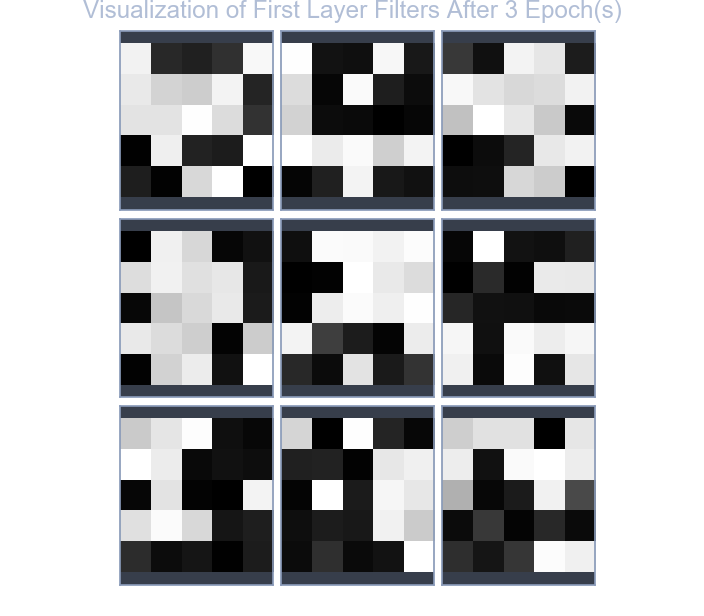

<IPython.core.display.Javascript object>


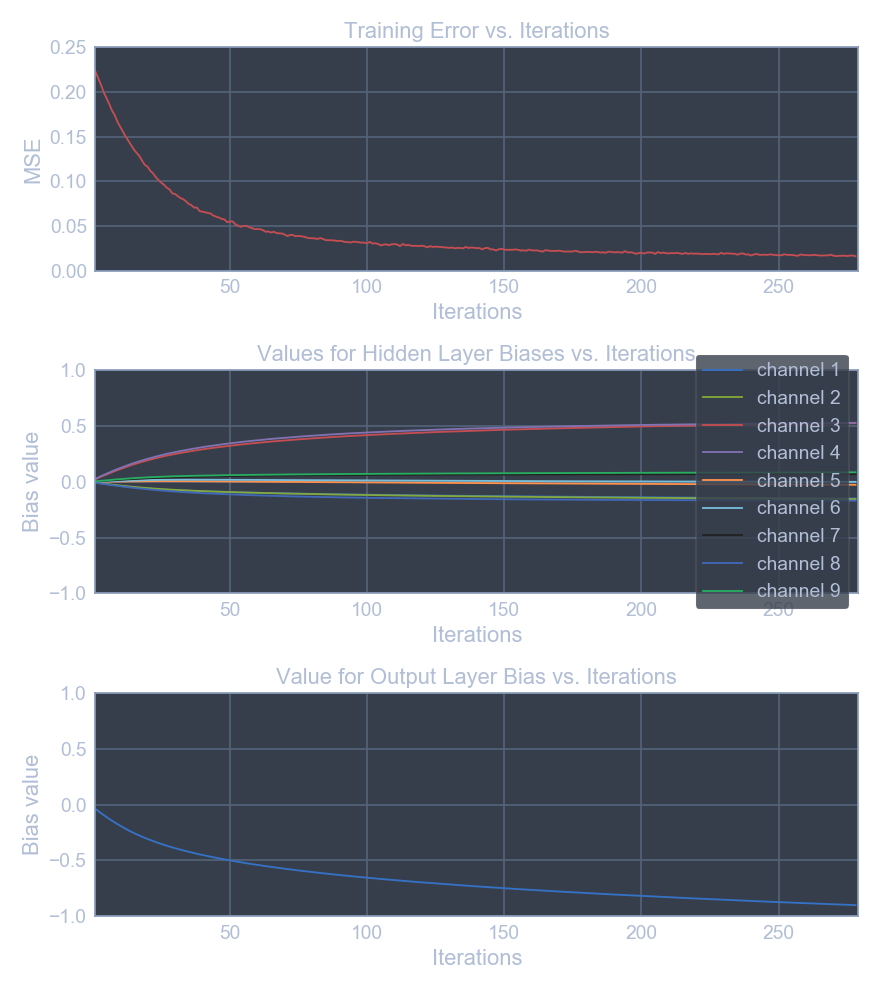

Text(0.5,1,'Value for Output Layer Bias vs. Iterations')

In [24]:
epoch = 0
iter  = 0
train_mse_error = 0

plt.ion()

# write plotting functions for hidden layer weights as image
fig_weights, ax_weights = plt.subplots(3, 3, sharex='col', 
                                        sharey='row',
                                        gridspec_kw=dict(
                                                wspace=0.05,
                                                hspace=0.05, 
                                                top=0.95,
                                                bottom=0.05,
                                                left=0.17,
                                                right=0.845))

fig_weights.show()
weights = hidden_layer_params[0].get_value()
update_weight(weights, ax_weights, fig_weights, epoch)


fig = plt.figure(figsize=(8, 9))
ax1 = fig.add_subplot(311)
line1,  = ax1.plot(iter,  train_mse_error, 'r-')

ax1.set_xlim(1, n_train_batches*num_epochs)
ax1.set_ylim(0,0.25)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')
ax1.set_title('Training Error vs. Iterations')

# create plotting functions for input layer biases
hidden_layer_biases = hidden_layer_params[1].get_value()
bias_channel1 = hidden_layer_biases[0]
bias_channel2 = hidden_layer_biases[1]
bias_channel3 = hidden_layer_biases[2]
bias_channel4 = hidden_layer_biases[3]
bias_channel5 = hidden_layer_biases[4]
bias_channel6 = hidden_layer_biases[5]
bias_channel7 = hidden_layer_biases[6]
bias_channel8 = hidden_layer_biases[7]
bias_channel9 = hidden_layer_biases[8]
ax2    = fig.add_subplot(312)
line21, = ax2.plot(iter, bias_channel1) 
line22, = ax2.plot(iter, bias_channel2) 
line23, = ax2.plot(iter, bias_channel3) 
line24, = ax2.plot(iter, bias_channel4) 
line25, = ax2.plot(iter, bias_channel5) 
line26, = ax2.plot(iter, bias_channel6) 
line27, = ax2.plot(iter, bias_channel7) 
line28, = ax2.plot(iter, bias_channel8) 
line29, = ax2.plot(iter, bias_channel9) 
line2 = [line21, line22, line23, line24, line25, line26, 
         line27, line28, line29]
ax2.set_xlim(1, n_train_batches*num_epochs)
ax2.set_ylim(-1, 1)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Bias value')
ax2.set_title('Values for Hidden Layer Biases vs. Iterations')
ax2.legend(line2, ['channel 1','channel 2', 'channel 3',
                   'channel 4','channel 5', 'channel 6',
                   'channel 7','channel 8', 'channel 9'],
                   loc='right')

# create plotting functions for output layer bias 
output_layer_biases = output_layer_params[1].get_value()
ax3    = fig.add_subplot(313)
line3, = ax3.plot(iter,  output_layer_biases, 'b-')

ax3.set_xlim(1, n_train_batches*num_epochs)
ax3.set_ylim(-1, 1)
ax3.set_xlabel('Iterations')
ax3.set_ylabel('Bias value')
ax3.set_title('Value for Output Layer Bias vs. Iterations')


In [25]:
plt.tight_layout()
fig.show()

import timeit
print('...training model...')

start_time = timeit.default_timer()
while (epoch < num_epochs):
    epoch = epoch + 1
    print('Training at Epoch = ', epoch)
    for minibatch_index in range(n_train_batches):
        iter = (epoch - 1) * n_train_batches + minibatch_index
        train_mse_error = train_model(minibatch_index)
        hidden_bias, output_bias = evaluate_biases()
        update_ax1(line1, fig, iter, train_mse_error)
        update_ax2(line2, fig, iter, hidden_bias)
        update_ax3(line3, fig, iter, output_bias)
        if iter %20 == 0:
            print ("Cost after the parameter update (epoch %d, iter %d) : %f" 
            %(epoch , iter, train_mse_error))
            print ("Output bias (epoch %d, iter %d) : %f " 
            %(epoch , iter, output_bias))
            
    weights = hidden_layer_params[0].get_value()
    update_weight(weights, ax_weights, fig_weights, epoch)     
end_time = timeit.default_timer() 

test_mse_error = [test_model(i) for i in range(n_test_batches)]         
print('\n....training is finished.')
print('\nThe code ran for %f minutes' %((end_time - start_time) / 60.))
print('Training MSE error is : %f' 
      % (np.mean(train_mse_error)))
print('Prediction MSE error is : %f' 
      % (np.mean(test_mse_error)))
plt.ioff()

...training model...
Training at Epoch =  1
Cost after the parameter update (epoch 1, iter 0) : 0.233741
Output bias (epoch 1, iter 0) : -0.020207 
Cost after the parameter update (epoch 1, iter 20) : 0.116489
Output bias (epoch 1, iter 20) : -0.308691 
Cost after the parameter update (epoch 1, iter 40) : 0.066134
Output bias (epoch 1, iter 40) : -0.452241 
Cost after the parameter update (epoch 1, iter 60) : 0.046569
Output bias (epoch 1, iter 60) : -0.540718 
Cost after the parameter update (epoch 1, iter 80) : 0.036372
Output bias (epoch 1, iter 80) : -0.605013 
Training at Epoch =  2
Cost after the parameter update (epoch 2, iter 100) : 0.030584
Output bias (epoch 2, iter 100) : -0.655584 
Cost after the parameter update (epoch 2, iter 120) : 0.028035
Output bias (epoch 2, iter 120) : -0.697376 
Cost after the parameter update (epoch 2, iter 140) : 0.025273
Output bias (epoch 2, iter 140) : -0.733418 
Cost after the parameter update (epoch 2, iter 160) : 0.022798
Output bias (epoch

In order to visualize the reconstructed images, we can run the code snippet below. It will show 5 randomly selected original images in the test dataset, binarized images and the reconstructed versions. 

<IPython.core.display.Javascript object>


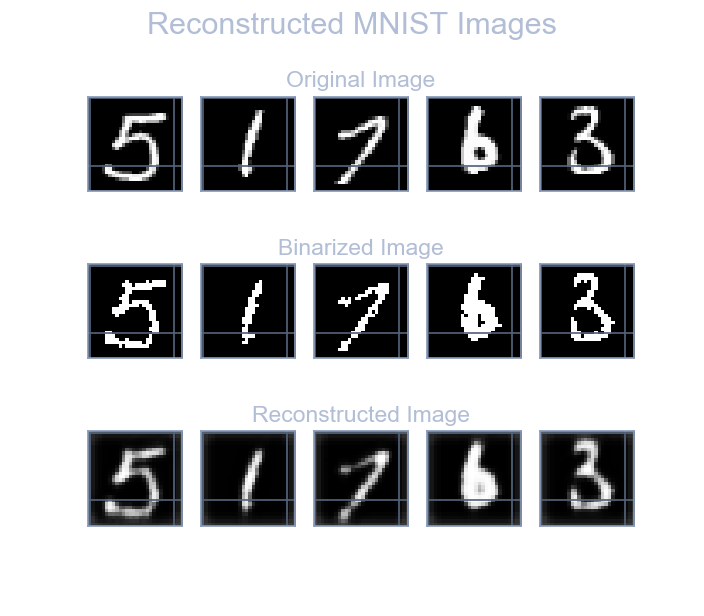

<IPython.core.display.Javascript object>


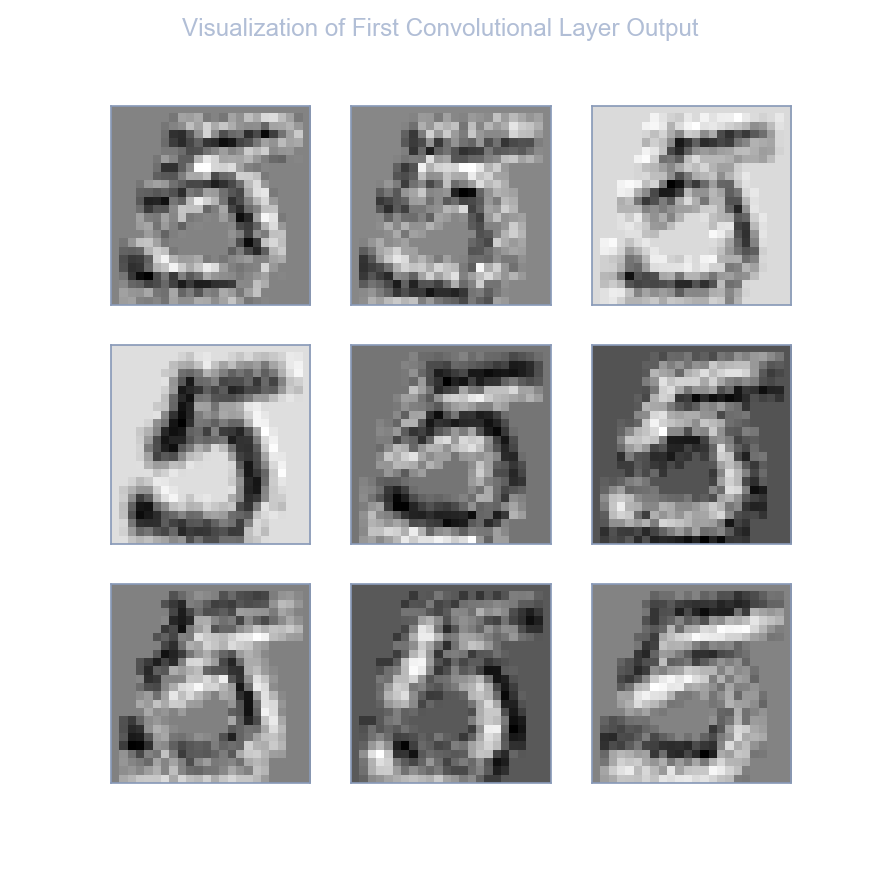

In [26]:
ind = np.random.randint(n_test_batches)

show_output = theano.function([],
        [input_layer_binarized, 
        hidden_layer_output, output],
        givens={x: test_set_x[ind * batch_size: (ind + 1) * batch_size]})

binarized_input, conv_layer_output, predicted_output = show_output()

# four axes, returned as a 2D array
f, axarr = plt.subplots(3, 5)
for i in range(5):
    axarr[0,i].imshow(
        (test_set_x[ind*batch_size+i].eval()).reshape(W,W).astype('float32'), cmap='gray')
    axarr[1,i].imshow(
        binarized_input[i].reshape(W,W).astype('float32'), cmap='gray')
    axarr[2,i].imshow(
        predicted_output[i].reshape(W,W).astype('float32'), cmap='gray')
    # Turn off tick labels
    axarr[0,i].set_yticklabels([])
    axarr[0,i].set_xticklabels([])
    axarr[1,i].set_yticklabels([])
    axarr[1,i].set_xticklabels([])
    axarr[2,i].set_yticklabels([])
    axarr[2,i].set_xticklabels([])
axarr[0,2].set_title('Original Image', fontsize=15)
axarr[1,2].set_title('Binarized Image', fontsize=15)
axarr[2,2].set_title('Reconstructed Image', fontsize=15)
plt.suptitle('Reconstructed MNIST Images', fontsize=20)
plt.show()

fig_conv, ax_conv = plt.subplots(3, 3, figsize=(8, 8))
fig_conv.suptitle(
    "Visualization of First Convolutional Layer Output")
for row in range(3):
    for col in range(3):
        idx = row*3 + col
        pixels = np.array(conv_layer_output[0][idx])
        ax_conv[row, col].imshow(pixels,
                 cmap='gray',
                 interpolation='none')
        ax_conv[row, col].set_xticklabels([])
        ax_conv[row, col].set_yticklabels([])
        ax_conv[row, col].set_xticks([])
        ax_conv[row, col].set_yticks([])
        
plt.show()